<a href="https://colab.research.google.com/github/Iasonaspg/ser-repo/blob/main/SER_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://developer.nvidia.com/compute/cuda/9.0/Prod/local_installers/cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls  # Check if required cuda 9.0 amd64-deb file is downloaded
!dpkg -i cuda-repo-ubuntu1704-9-0-local_9.0.176-1_amd64-deb
!ls /var/cuda-repo-9-0-local | grep .pub
!apt-key add /var/cuda-repo-9-0-local/7fa2af80.pub
!apt-get update
!sudo apt-get install cuda-9.0

In [ ]:
!pip install thundersvm

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Emotions/')
!ls 

anger  disgust	fear  happiness  sadness


In [ ]:
!python -m pip install -U pip
!pip uninstall librosa
!pip install librosa

import numpy as np
import scipy
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio, display

In [ ]:
print(librosa.__version__)

0.8.0


In [ ]:
# load audio file
from pathlib import Path
fs = 22050
n_fft, hop = 1024, 256

# Fucntions require you to be in the root data directory
def get_train_wav_dir(dir_name,fs=44100):
  return [ librosa.load(p,fs)[0] for p in Path().glob('./' + dir_name + '/train' + '/*.wav') ]

def get_test_wav_dir(dir_name,fs=44100):
  return [ librosa.load(p,fs)[0] for p in Path().glob('./' + dir_name + '/test' + '/*.wav') ]



emotions = ["sadness","happiness","anger","fear","disgust"]

# list of len(emotions) that contains lists of numpy arrays. Each numpy array belongs to a single wav file
train_wav = []
test_wav = []
for emotion in emotions:
  train_wav.append(get_train_wav_dir(emotion,fs))
  test_wav.append(get_test_wav_dir(emotion,fs))




In [ ]:
from numpy import genfromtxt

os.chdir('/content/drive/My Drive/Br_CSV/')

# Create two lists that contains len(emotions) numpy arrays. Each row of the arrays represents the brightness x% of an entire emotion for the total of the emotion wav files, divided in frames
br_train = []
br_test = []
for emotion in emotions:
  filename = 'br_' + emotion + '_train.csv'
  temp = genfromtxt(filename,delimiter=',')
  np.nan_to_num(temp,copy=False)
  br_train.append(temp)
  filename = 'br_' + emotion + '_test.csv'
  temp = genfromtxt(filename,delimiter=',')
  np.nan_to_num(temp,copy=False)
  br_test.append(temp)



print(br_train[0].shape)
print(br_train[1].shape)
print(br_train[2].shape)
print(br_train[3].shape)
print(br_train[4].shape)


(2, 32013)
(2, 28208)
(2, 25665)
(2, 27131)
(2, 34553)


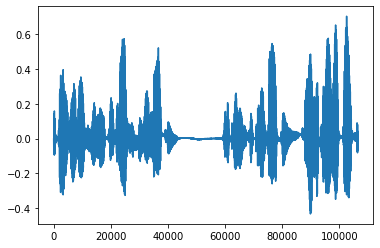

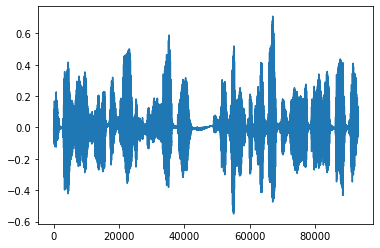

In [ ]:
# for i in range(len(train_wav)):
#   for j in range(len(train_wav[i])):
#     train_wav[i][j], _ = librosa.effects.trim(train_wav[i][j],top_db=15,frame_length=128,hop_length=32)
#     #display(Audio(i, rate=fs))
#     #plt.plot(i)
#     #plt.show()
#     #plt.plot(i_t)
#     #plt.show()

# for i in range(len(test_wav)):
#   for j in range(len(test_wav[i])):
#     test_wav[i][j], _ = librosa.effects.trim(test_wav[i][j],top_db=15,frame_length=128,hop_length=32)

# # print(index)
os.chdir('/content/drive/My Drive/Emotions/')

y1, _ = librosa.load("./sadness/train/trimmed_s01 (6).wav",fs)
x1, _ = librosa.load("./happiness/train/trimmed_h01 (6).wav",fs)


display(Audio(y1, rate=fs))
plt.plot(y1)
plt.show()
display(Audio(x1, rate=fs))
plt.plot(x1)
plt.show()


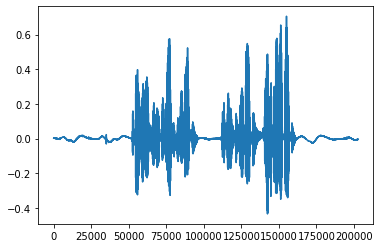

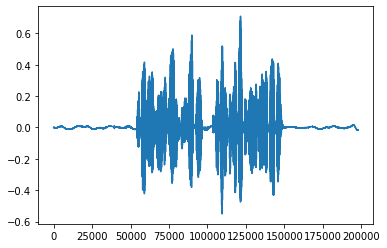

In [ ]:
os.chdir('/content/drive/My Drive/Acted Emotional Speech Dynamic Database.zip (Unzipped Files)/Acted Emotional Speech Dynamic Database/')

y,_ = librosa.load("./sadness/train/s01 (6).wav",fs)
x,_ = librosa.load("./happiness/train/h01 (6).wav",fs)


display(Audio(y, rate=fs))
plt.plot(y)
plt.show()
display(Audio(x, rate=fs))
plt.plot(x)
plt.show()

In [ ]:
display(Audio(train_wav[0][0], rate=fs))
print(train_wav[1][0].shape)
print(n_fft,hop)

(100986,)
512 128


In [245]:
from librosa.feature import spectral

# Gets a list of wav signals and returns a numpy array of features x nFrames_total and a list of len(input) containing the nFrames per signal
def extract_features(wav):
  spectral_centroid = spectral.spectral_centroid(wav[0], sr=fs, n_fft=n_fft, hop_length=hop, center=False)
  spectral_rolloff = spectral.spectral_rolloff(wav[0], sr=fs, n_fft=n_fft, hop_length=hop,roll_percent=0.30, center=False)
  spectral_rolloff50 = spectral.spectral_rolloff(wav[0], sr=fs, n_fft=n_fft, hop_length=hop,roll_percent=0.50, center=False)
  zero_crossing_rate = spectral.zero_crossing_rate(wav[0], frame_length=n_fft, hop_length=hop, center=False)

  mfcc = librosa.feature.mfcc(wav[0], sr=fs, n_fft=n_fft, hop_length=hop, n_mfcc=7, center=False)
  desired_mfcc = np.concatenate((mfcc[1:2,:],mfcc[3:5,:],mfcc[6:7,:]),axis=0)
  rms = librosa.feature.rms(wav[0],frame_length=n_fft,hop_length=hop,center=False)
  # mfcc_delta = librosa.feature.delta(desired_mfcc, order=1, mode='nearest')
  # mfcc_delta2 = librosa.feature.delta(desired_mfcc, order=2, mode='nearest')
  feature_vector = np.concatenate((spectral_centroid,spectral_rolloff,spectral_rolloff50,zero_crossing_rate,desired_mfcc,rms),axis=0)
  nFrames = [0 for i in range(len(wav))]
  nFrames[0] = spectral_centroid.shape[1]
  for i in range(1,len(wav)):
    cols = wav[i].shape[0]
    spectral_centroid = spectral.spectral_centroid(wav[i], sr=fs, n_fft=n_fft, hop_length=hop, center=False)
    spectral_rolloff = spectral.spectral_rolloff(wav[i], sr=fs, n_fft=n_fft, hop_length=hop,roll_percent=0.30, center=False)
    spectral_rolloff50 = spectral.spectral_rolloff(wav[i], sr=fs, n_fft=n_fft, hop_length=hop,roll_percent=0.50, center=False)

    zero_crossing_rate = spectral.zero_crossing_rate(wav[i], frame_length=n_fft, hop_length=hop, center=False)
    mfcc = librosa.feature.mfcc(wav[i], sr=fs, n_fft=n_fft, hop_length=hop, n_mfcc=7, center=False)
    desired_mfcc = np.concatenate((mfcc[1:2,:],mfcc[3:5,:],mfcc[6:7,:]),axis=0)
    rms = librosa.feature.rms(wav[i],frame_length=n_fft,hop_length=hop,center=False)
    # mfcc_delta = librosa.feature.delta(desired_mfcc, order=1, mode='nearest')
    # mfcc_delta2 = librosa.feature.delta(desired_mfcc, order=2, mode='nearest')
    feature_vector1 = np.concatenate((spectral_centroid,spectral_rolloff,spectral_rolloff50,zero_crossing_rate,desired_mfcc,rms),axis=0)
    feature_vector = np.concatenate((feature_vector,feature_vector1),axis=1)
    nFrames[i] = spectral_centroid.shape[1]
  return feature_vector, nFrames


test_nframes = []
train_nframes = []
feature_train_vector, _ = extract_features(train_wav[0])
label_vec = [0 for i in range(feature_train_vector.shape[1])]
feature_train_vector = np.concatenate((feature_train_vector,br_train[0],np.array([label_vec])),axis=0)

feature_test_vector, test_nframe = extract_features(test_wav[0])
label_vec = [0 for i in range(feature_test_vector.shape[1])]
feature_test_vector = np.concatenate((feature_test_vector,br_test[0],np.array([label_vec])),axis=0)
test_nframes.append(test_nframe)
for i in range(1,len(train_wav)):
  train_feat_vec, train_nframe = extract_features(train_wav[i])
  train_nframes.append(train_nframe)
  label_vec = [i for j in range(train_feat_vec.shape[1])]
  train_feat_vec = np.concatenate((train_feat_vec,br_train[i],np.array([label_vec])),axis=0)
  feature_train_vector = np.concatenate((feature_train_vector,train_feat_vec),axis=1)

  
  test_feat_vec, test_nframe = extract_features(test_wav[i])
  test_nframes.append(test_nframe)
  label_vec = [i for j in range(test_feat_vec.shape[1])]
  test_feat_vec = np.concatenate((test_feat_vec,br_test[i],np.array([label_vec])),axis=0)
  feature_test_vector = np.concatenate((feature_test_vector,test_feat_vec),axis=1)


print(feature_test_vector.shape)
#print(happy_train_feat_vec.shape)
print('=')
print(feature_train_vector.shape)
#print(feature_vector[:,0:2])

(12, 25205)
=
(12, 147570)


In [ ]:
import librosa.display
y,_ = librosa.load("./sadness/train/trimmed_s01 (6).wav",fs)
y1,_ = librosa.load("./happiness/train/trimmed_h01 (6).wav",fs)

def get_spectr(wav,em):
  S, phase = librosa.magphase(librosa.stft(y=wav, n_fft=n_fft, hop_length=hop, center=False))
  print(S.shape)
  cent = spectral.spectral_centroid(S=S)
  rol30 = spectral.spectral_rolloff(S=S, sr=fs,roll_percent=0.30)
  rol50 = spectral.spectral_rolloff(S=S, sr=fs,roll_percent=0.50)

  times = librosa.times_like(cent)
  times30 = librosa.times_like(rol30)
  times50 = librosa.times_like(rol50)
  fig, ax = plt.subplots(figsize=(10,7))
  img = librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.min), y_axis='log', x_axis='time', ax=ax)
  ax.plot(times, cent.T, label='Spectral centroid', color='w')
  ax.plot(times30, rol30.T, label='Spectral rolloff 30', color='#95eddf')
  ax.plot(times50, rol50.T, label='Spectral rolloff 50', color='b')
  fig.colorbar(img, ax=ax, format="%+2.f dB")
  ax.legend(loc='upper right')
  ax.set(title= em + ' log Power spectrogram')
  plt.show()

get_spectr(y,"sad")
get_spectr(y1,"happy")

In [ ]:
print(feature_train_vector[:,131130])

[ 5.94429251e+03  4.90957031e+03  6.13696289e+03  5.41992188e-01
 -1.18576645e+02  4.87268066e+01 -1.97425385e+01 -9.49008369e+00
  1.48726642e-01 -1.35814381e+01  7.16708481e-01 -4.55100155e+00
 -6.36391401e-01  7.51859760e+00 -4.89887118e-01 -5.49362935e-02
  1.70328379e-01  9.94840000e-01  9.90660000e-01  4.00000000e+00]


In [246]:
import pandas as pd
feat_train = feature_train_vector[0:11,:].T

pd_feat_train = pd.DataFrame(feat_train)
pd_feat_train.describe()

,0,1,2,3,4,5,6,7,8,9,10
count,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000
mean,2466.849859,1094.105888,1796.321196,0.135340,69.904337,8.923558,-5.913831,-12.793342,0.074399,0.840143,0.667034
std,1568.838165,1447.979581,1888.746918,0.147026,63.951290,29.482764,27.270888,20.128150,0.060985,0.199235,0.237168
min,26.587444,0.000000,0.000000,0.000000,-235.525085,-107.764870,-149.226013,-100.508789,0.000081,0.000000,0.000000
25%,1408.982815,322.998047,538.330078,0.045898,37.315625,-10.931899,-22.989209,-25.982828,0.025422,0.775510,0.512320
50%,1956.965492,495.263672,990.527344,0.076172,79.371826,7.661649,-5.786995,-11.890460,0.061680,0.907740,0.697565
75%,2956.028462,968.994141,2217.919922,0.150391,113.570728,27.577981,11.082223,1.120397,0.108945,0.980080,0.864457
max,8398.838795,8161.083984,9259.277344,0.805664,251.672791,170.622467,115.711357,81.680939,0.427108,0.999950,0.999920


In [ ]:
a = np.asarray(feature_train_vector)
np.savetxt("feature_train_vector.csv", a, delimiter=",")

a = np.asarray(feature_test_vector)
np.savetxt("feature_test_vector.csv", a, delimiter=",")

In [ ]:
import os
os.chdir('/content/drive/My Drive/Br_CSV/')

feature_train_vector = np.genfromtxt("feature_train_vector.csv", delimiter=",")
feature_test_vector = np.genfromtxt("feature_test_vector.csv", delimiter=",")
print(feature_train_vector.shape)

In [ ]:
import sklearn
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

X_train = feat_train
Y_train = feature_train_vector[11,:].T

X_test = feature_test_vector[0:11,:].T
Y_test = feature_test_vector[11,:].T

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler = Normalizer()
scaler.fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

pd_feat_train_norm = pd.DataFrame(X_train_norm)

pca = sklearn.decomposition.PCA(n_components=11)
pca_train = pca.fit_transform(X_train_scaled)

pd_feat_train_scal = pd.DataFrame(X_train_scaled)
pd_feat_train_scal.describe()



# fig, axes = plt.subplots(1,2)
# axes[0].scatter(feature_train_vector[3:4,:].T, feature_train_vector[12:13,:].T, c=feature_train_vector[14,].T)
# axes[0].set_xlabel('x1')
# axes[0].set_ylabel('x2')
# axes[0].set_title('Before PCA')
# axes[1].scatter(pca_train[3:4,:], pca_train[12:13,:], c=feature_train_vector[14,].T)
# axes[1].set_xlabel('PC1')
# axes[1].set_ylabel('PC2')
# axes[1].set_title('After PCA')
# plt.show()



,0,1,2,3,4,5,6,7,8,9,10
count,1.475700e+05,1.475700e+05,1.475700e+05,1.475700e+05,1.475700e+05,1.475700e+05,1.475700e+05,1.475700e+05,1.475700e+05,1.475700e+05,1.475700e+05
mean,-2.869991e-16,-6.434622e-16,4.729865e-16,-5.696105e-16,-1.501920e-16,8.849520e-16,8.186164e-16,-1.697735e-15,-9.458826e-17,-1.869193e-15,-4.689240e-15
std,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00,1.000003e+00
min,-1.555464e+00,-7.556112e-01,-9.510683e-01,-9.205255e-01,-4.775986e+00,-3.957866e+00,-5.255152e+00,-4.357864e+00,-1.218636e+00,-4.216850e+00,-2.812513e+00
25%,-6.743019e-01,-5.325424e-01,-6.660476e-01,-6.083447e-01,-5.095882e-01,-6.734621e-01,-6.261415e-01,-6.552779e-01,-8.031023e-01,-3.244069e-01,-6.523449e-01
50%,-3.250087e-01,-4.135723e-01,-4.266303e-01,-4.024382e-01,1.480427e-01,-4.280175e-02,4.650963e-03,4.485678e-02,-2.085652e-01,3.392825e-01,1.287302e-01
75%,3.118105e-01,-8.640465e-02,2.232169e-01,1.023648e-01,6.828094e-01,6.327251e-01,6.232328e-01,6.912601e-01,5.664651e-01,7.023717e-01,8.324229e-01
max,3.781148e+00,4.880595e+00,3.951287e+00,4.559244e+00,2.842305e+00,5.484542e+00,4.459906e+00,4.693655e+00,5.783569e+00,8.021033e-01,1.403593e+00


In [ ]:
pd_feat_train_norm.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
count,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,1.475700e+05,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,147570.000000,1.475700e+05,1.475700e+05,147570.000000,147570.000000
mean,0.813851,0.267143,0.459782,0.000036,0.048494,0.004378,-0.001372,-0.004994,4.053999e-05,-0.000040,-0.000034,0.000045,0.000060,-0.000623,0.000010,-3.284896e-05,1.232342e-05,0.000393,0.000291
std,0.111783,0.119764,0.148253,0.000015,0.052820,0.018066,0.018014,0.013337,5.434900e-05,0.004833,0.002410,0.002342,0.001702,0.002559,0.001223,1.196092e-03,9.392801e-04,0.000417,0.000304
min,0.531723,0.000000,0.000000,0.000000,-0.023827,-0.071685,-0.126712,-0.118127,2.133107e-08,-0.077437,-0.038229,-0.053964,-0.042837,-0.028691,-0.025951,-5.992765e-02,-1.578222e-02,0.000000,0.000000
25%,0.732914,0.178866,0.346964,0.000026,0.010329,-0.004249,-0.008482,-0.010942,5.660818e-06,-0.002025,-0.000981,-0.000832,-0.000640,-0.001526,-0.000471,-4.705572e-04,-3.719876e-04,0.000216,0.000173
50%,0.837572,0.250427,0.461158,0.000034,0.035108,0.002326,-0.001571,-0.003575,2.564664e-05,-0.000072,0.000023,0.000023,0.000011,-0.000061,0.000005,-4.974656e-07,-7.275641e-07,0.000372,0.000275
75%,0.904807,0.342294,0.591264,0.000045,0.070124,0.010228,0.004279,0.000351,5.818833e-05,0.002019,0.001001,0.000948,0.000746,0.000753,0.000521,4.289817e-04,4.020952e-04,0.000511,0.000366
max,0.999926,0.568995,0.818576,0.000199,0.622526,0.433539,0.417333,0.377374,2.576957e-03,0.072855,0.045080,0.048717,0.023313,0.076732,0.027623,2.062636e-02,1.196105e-02,0.027172,0.016733


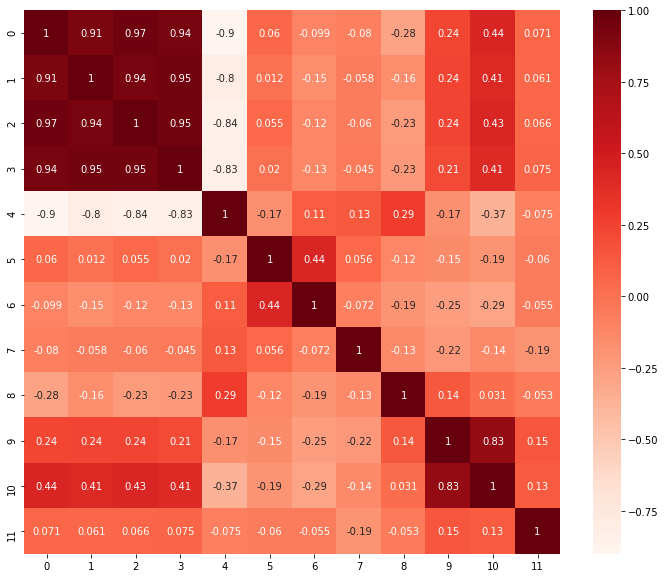

In [ ]:
import seaborn as sns
import statsmodels.api as sm

scaler = StandardScaler()
scaler.fit(feature_train_vector.T)
trainn_scaled = scaler.transform(feature_train_vector.T)

df = pd.DataFrame(trainn_scaled)
plt.figure(figsize=(12,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [ ]:
print(pca.explained_variance_ratio_,"\n")
#print(pca.explained_variance_)
print(abs( pca.components_ )[0],"\n")
print(abs( pca.components_ )[1],"\n")
print(abs( pca.components_ )[2],"\n")


[0.45898836 0.18445217 0.10917218 0.08420134 0.07363694 0.04727232
 0.01770402 0.01206123 0.00654206 0.00395527 0.0020141 ] 

[0.4316809  0.41911525 0.4290978  0.4241744  0.39731315 0.00778897
 0.08530732 0.05152185 0.10993973 0.16998786 0.25517113] 

[0.10364671 0.05833394 0.08824178 0.0917523  0.13893315 0.41772474
 0.42125962 0.16913529 0.34903215 0.50317769 0.44133365] 

[0.02544539 0.0772057  0.04433198 0.08415595 0.02952991 0.45294946
 0.51847845 0.58916932 0.10520509 0.3316357  0.20326904] 



In [ ]:
from thundersvm import SVC
import time

clf = SVC(C=15.0,gamma=5.0,kernel='rbf')
str = time.time()
clf.fit(X_train_scaled, Y_train)
print(time.time()-str)

In [ ]:
from joblib import dump, load
from sklearn import svm
import time


#X_train = feature_train_vector[0:14,:].T
#Y_train = feature_train_vector[14,:].T
#Y_test = feature_test_vector[14,:].T
#X_test = feature_test_vector[0:14,:].T

clf = svm.SVC(C=10.0)
str = time.time()
clf.fit(X_train, Y_train)
print(time.time()-str)

dump(clf, './svm_norm11_c10.joblib') 

In [ ]:
from joblib import dump, load
from sklearn import svm

clf = load('./svm_stand11_c10.joblib')

In [ ]:
import statistics 
from statistics import mode,mean

def get_label(y):
  return mode(y)



In [ ]:
from sklearn.metrics import accuracy_score

print("CPU: \n")

accuracy_list = []

i = 0
for k in test_nframes:
  for j in k:
    pred = clf.predict(X_test_scaled[i:i+j,:])
    acc = accuracy_score(Y_test[i:i+j,],pred,True)
    accuracy_list.append(acc)
    print(acc)
    i = i + j

print("Mean CPU accuracy: ", np.mean(accuracy_list))

In [ ]:
from sklearn import metrics
pred = clf.predict(X_test_scaled)
print(metrics.classification_report(Y_test, pred, digits=3))

              precision    recall  f1-score   support

         0.0      0.527     0.641     0.579      5622
         1.0      0.351     0.243     0.287      4555
         2.0      0.384     0.368     0.376      4522
         3.0      0.353     0.259     0.299      4564
         4.0      0.375     0.476     0.419      5942

    accuracy                          0.412     25205
   macro avg      0.398     0.397     0.392     25205
weighted avg      0.402     0.412     0.401     25205



In [ ]:
from sklearn import metrics
#from sklearn.metrics import accuracy_score

def acc_mode(clf,X_test):
  accuracy_list = []
  y_pred = []
  y_true = []

  i = 0
  label = 0
  for k in test_nframes:
    for j in k:
      pred = clf.predict(X_test_scaled[i:i+j,:])
      try:
        val = mode(pred)
      except:
        #print(pred)
        val = round(mean(pred))
      y_pred.append(val)
      y_true.append(label)
      i = i + j
    label = label + 1

  # Print the confusion matrix
  print(metrics.confusion_matrix(y_true, y_pred))
  print(metrics.accuracy_score(y_true, y_pred))

  # Print the precision and recall, among other metrics
  print(metrics.classification_report(y_true, y_pred, digits=3))

acc_mode(clf,X_test_scaled)

[[13  0  0  0  5]
 [ 1  2  2  0 12]
 [ 1  0  5  0 12]
 [ 2  1  3  1 10]
 [ 1  0  0  0 17]]
0.4318181818181818
              precision    recall  f1-score   support

           0      0.722     0.722     0.722        18
           1      0.667     0.118     0.200        17
           2      0.500     0.278     0.357        18
           3      1.000     0.059     0.111        17
           4      0.304     0.944     0.459        18

    accuracy                          0.432        88
   macro avg      0.638     0.424     0.370        88
weighted avg      0.634     0.432     0.375        88



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

clf_lgr = LogisticRegression(C=10,random_state=0,solver='sag',max_iter=50)
str = time.time()
clf_lgr.fit(X_train_scaled, Y_train)
print("Log Reg train time",time.time()-str,"s\n")
clf_lgr.predict(X_test_scaled)
print(clf_lgr.score(X_test_scaled, Y_test))

pred = clf_lgr.predict(X_test_scaled)
print(accuracy_score(Y_test,pred,True))

acc_mode(clf_lgr,X_test_scaled)

Log Reg train time 2.520251512527466 s

0.3719896845863916
0.3719896845863916
[[16  0  1  1  0]
 [ 3  2  6  0  6]
 [ 3  0 10  1  4]
 [ 6  2  2  3  4]
 [ 2  0  0  1 15]]
0.5227272727272727
              precision    recall  f1-score   support

           0      0.533     0.889     0.667        18
           1      0.500     0.118     0.190        17
           2      0.526     0.556     0.541        18
           3      0.500     0.176     0.261        17
           4      0.517     0.833     0.638        18

    accuracy                          0.523        88
   macro avg      0.515     0.514     0.459        88
weighted avg      0.516     0.523     0.465        88



In [ ]:
print("CPU: \n")

accuracy_list = []

i = 0
for k in test_nframes:
  for j in k:
    pred = clf_lgr.predict(X_test_scaled[i:i+j,:])
    acc = accuracy_score(Y_test[i:i+j,],pred,True)
    #acc = clf_lgr.score(feature_test_vector[0:8,i:i+j].T,feature_test_vector[8,i:i+j])
    accuracy_list.append(acc)
    #print(acc)
    i = i + j
  
print("Mean CPU accuracy: ", np.mean(accuracy_list))

CPU: 

Mean CPU accuracy:  0.35903741354149044


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(criterion='entropy')
str = time.time()
dtree.fit(X_train_scaled, Y_train)
print("time: ",time.time()-str)

time:  7.349299669265747


In [ ]:
pred = dtree.predict(X_test_scaled)
print(metrics.classification_report(Y_test, pred, digits=3))

In [ ]:
acc_mode(dtree,X_test_scaled)

[[17  1  0  0  0]
 [ 2  7  4  0  4]
 [ 2  0 13  0  3]
 [ 6  3  2  6  0]
 [ 3  0  1  1 13]]
0.6363636363636364
              precision    recall  f1-score   support

           0      0.567     0.944     0.708        18
           1      0.636     0.412     0.500        17
           2      0.650     0.722     0.684        18
           3      0.857     0.353     0.500        17
           4      0.650     0.722     0.684        18

    accuracy                          0.636        88
   macro avg      0.672     0.631     0.615        88
weighted avg      0.670     0.636     0.618        88



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train_scaled,Y_train)

acc_mode(knn,X_test_scaled)

[[17  1  0  0  0]
 [ 2  9  4  0  2]
 [ 2  4 12  0  0]
 [ 8  3  2  3  1]
 [ 3  1  3  0 11]]
0.5909090909090909
              precision    recall  f1-score   support

           0      0.531     0.944     0.680        18
           1      0.500     0.529     0.514        17
           2      0.571     0.667     0.615        18
           3      1.000     0.176     0.300        17
           4      0.786     0.611     0.688        18

    accuracy                          0.591        88
   macro avg      0.678     0.586     0.559        88
weighted avg      0.676     0.591     0.563        88



In [ ]:
def ensemble_acc(clf,X,Y):
  accuracy_list = []
  y_pred = []
  y_true = []

  i = 0
  label = 0
  count = 0
  for k in test_nframes:
    for j in k:
      pred0 = clf[0].predict(X[i:i+j,:])
      pred1 = clf[1].predict(X[i:i+j,:])
      pred2 = clf[2].predict(X[i:i+j,:])
      pred = []
      for m in range(len(pred0)):
        try:
          val = mode([pred0[m],pred1[m],pred2[m]])
        except:
          val = pred0[m]
        pred.append(val)
      try:
        val = mode(pred)
      except:
        count = count + 1
        val = round(np.mean(pred))
      y_pred.append(val)
      y_true.append(label)
      i = i + j
    label = label + 1

  # Print the confusion matrix
  print(metrics.confusion_matrix(y_true, y_pred))

  # Print the precision and recall, among other metrics
  print(metrics.classification_report(y_true, y_pred, digits=3))

  print("Amb",count,"\n")


ensemble_acc([clf,dtree,knn],X_test_scaled,Y_test)

[[14  0  0  0  4]
 [ 1  3  1  0 12]
 [ 1  0  8  0  9]
 [ 6  2  2  1  6]
 [ 1  0  0  0 17]]
              precision    recall  f1-score   support

           0      0.609     0.778     0.683        18
           1      0.600     0.176     0.273        17
           2      0.727     0.444     0.552        18
           3      1.000     0.059     0.111        17
           4      0.354     0.944     0.515        18

    accuracy                          0.489        88
   macro avg      0.658     0.480     0.427        88
weighted avg      0.655     0.489     0.432        88

Amb 0 



<BarContainer object of 3 artists>

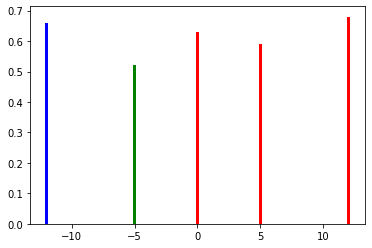

In [ ]:
svm = [0.58,0.57,0.66]
lgr = [0.52,0.51,0.51]
dtr = [0.63,0.59,0.63]
knn = [0.59,0.58,0.58]
ens = [0.6,0.68,0.66]

x = [0, 1, 2]

ax = plt.subplot(111)
ax.bar(-12, svm, width=0.2, color='b', align='center')
ax.bar(-5, lgr, width=0.2, color='g', align='center')
ax.bar(0, dtr, width=0.2, color='r', align='center')
ax.bar(5, knn, width=0.2, color='r', align='center')
ax.bar(12, ens, width=0.2, color='r', align='center')